In [2]:
!pip install textblob

DEPRECATION: Loading egg at /home/siddhantp/anaconda3/lib/python3.11/site-packages/ianvs-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re


nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

# Loading the cleaned dataset from task 1
data = pd.read_csv('mental_health_posts_20250323_121040.csv')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/siddhantp/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/siddhantp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siddhantp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment using VADER
def classify_sentiment_vader(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'Neutral'
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Function to classify sentiment using TextBlob
def classify_sentiment_textblob(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'Neutral'
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'


In [8]:
# Defining risk level lexicons(based on internet)
high_risk_terms = [
    "kill myself", "suicide", "end my life", "don't want to live", 
    "want to die", "better off dead", "can't take it anymore",
    "no reason to live", "ending it all", "taking my life",
    "overdose", "self harm", "cutting myself", "slitting",
    "hanging myself", "jump off", "fatal dose", "last day"
]

moderate_risk_terms = [
    "depressed", "depression", "anxiety", "panic attack", "hopeless",
    "overwhelmed", "struggling", "need help", "therapy", "counseling",
    "medication", "treatment", "mental health", "feeling lost",
    "can't cope", "exhausted", "tired of everything", "no motivation"
]

low_risk_terms = [
    "stress", "sad", "upset", "worried", "anxious", "mental wellness",
    "self care", "mindfulness", "meditation", "coping strategies",
    "feeling down", "bad day", "mental health awareness", "support"
]

# Function to determine risk level based on content
def classify_risk_level(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'Low Concern'
    
    text = text.lower()
    
    # for high risk terms
    if any(term in text for term in high_risk_terms):
        return 'High-Risk'
    
    # for moderate risk terms
    if any(term in text for term in moderate_risk_terms):
        return 'Moderate Concern'
    
    # Default to low concern
    return 'Low Concern'

# Applying risk level classification
data['risk_level'] = data.apply(lambda row: 
                              classify_risk_level(str(row.get('content', '')) + ' ' + 
                                               str(row.get('title', ''))), 
                              axis=1)

# Saving the dataset with sentiment and risk classification
data.to_csv('mental_health_posts_with_classification.csv', index=False)


In [9]:
# Now, Creating a more sophisticated risk classifier using TF-IDF
# Combining all risk terms for vectorization
all_risk_terms = high_risk_terms + moderate_risk_terms + low_risk_terms

#a document for each risk level
high_risk_doc = ' '.join(high_risk_terms)
moderate_risk_doc = ' '.join(moderate_risk_terms)
low_risk_doc = ' '.join(low_risk_terms)

# the corpus for TF-IDF
risk_corpus = [high_risk_doc, moderate_risk_doc, low_risk_doc]

# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.9)
tfidf_matrix = tfidf_vectorizer.fit_transform(risk_corpus)

# Getting feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to classify risk using TF-IDF similarity
def classify_risk_tfidf(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'Low Concern'
    
    # Transform the text using the fitted vectorizer
    text_vector = tfidf_vectorizer.transform([text.lower()])
    
    # Calculating similarity with each risk level
    similarities = [(text_vector * tfidf_matrix[i].T).toarray()[0][0] for i in range(3)]
    
    # Getting the index of the highest similarity
    max_sim_index = np.argmax(similarities)
    
    # Now mapping index to risk level
    risk_levels = ['High-Risk', 'Moderate Concern', 'Low Concern']
    return risk_levels[max_sim_index]

# Applying the TF-IDF based risk classification
data['risk_level_tfidf'] = data['cleaned_content'].apply(classify_risk_tfidf)



In [10]:
# Finally, comparing lexicon-based and TF-IDF based classifications
data['final_risk_level'] = data.apply(
    lambda row: 'High-Risk' if row['risk_level'] == 'High-Risk' or row['risk_level_tfidf'] == 'High-Risk'
    else ('Moderate Concern' if row['risk_level'] == 'Moderate Concern' or row['risk_level_tfidf'] == 'Moderate Concern'
         else 'Low Concern'), axis=1)



Distribution of Posts by Sentiment and Risk Level:
final_risk_level  High-Risk  Low Concern  Moderate Concern
sentiment                                                 
Negative                 57            2                41
Neutral                 314           42               213
Positive                150            3               100


<Figure size 1200x800 with 0 Axes>

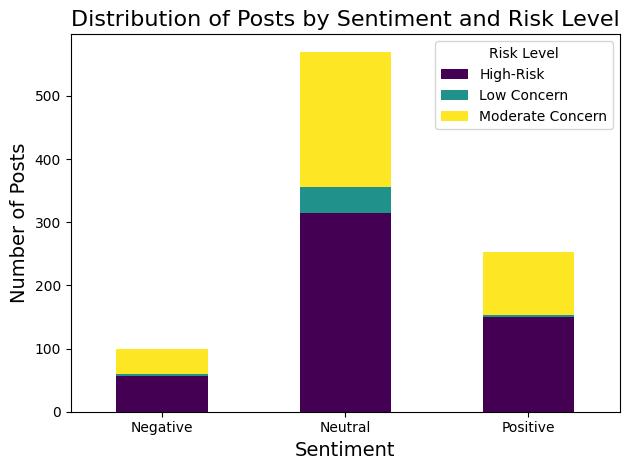

In [11]:
#Visualizing the results of the analysis
#A cross-tabulation of sentiment and risk level
sentiment_risk_table = pd.crosstab(data['sentiment'], data['final_risk_level'])
print("\nDistribution of Posts by Sentiment and Risk Level:")
print(sentiment_risk_table)

# Plotting the distribution
plt.figure(figsize=(12, 8))
sentiment_risk_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Posts by Sentiment and Risk Level', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Risk Level')
plt.tight_layout()
plt.savefig('sentiment_risk_distribution.png')



Analysis complete. Visualizations saved.


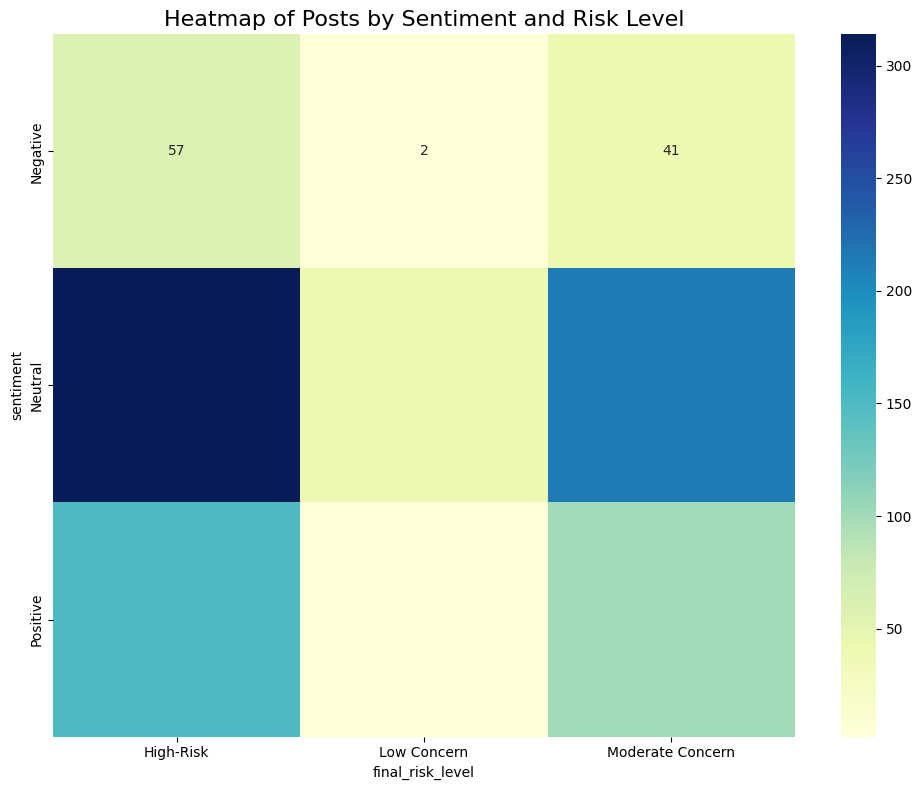

In [12]:
#A heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(sentiment_risk_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap of Posts by Sentiment and Risk Level', fontsize=16)
plt.tight_layout()
plt.savefig('sentiment_risk_heatmap.png')

print("Analysis complete. Visualizations saved.")